# Data Mining

* [Decision Tree From Scratch](#one)
* [Feature importance](#two)
* [Random Forests](#three)
* [Gradient Boosting](#four)
* [Application of Decision Trees & Ensemble Methods](#five)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, accuracy_score

## Decision Tree From Scratch <a class="anchor" id="one"></a>

In [26]:
def relative_proportion(i, D):
    """
    :param i: class name
    :param D: dataset
    """
    return len(D[D["Class"] == i])/len(D)

In [27]:
def entropy(D):
    """
    :param D: dataset
    """

    classes = D["Class"].unique()
    relative_props = [relative_proportion(i, D) for i in classes]

    return -np.sum(relative_props * np.log2(relative_props))

In [28]:
def information_gain(split_feature, D):
    """
    :param split_feature: feature for which split is performed
    :param D: dataset
    """
    weighted_entropy = 0
    feature_values = D[split_feature].unique()

    for v in feature_values:
        D_v = D[D[split_feature] == v]
        weighted_entropy += (len(D_v)/len(D)) * entropy(D_v)

    return entropy(D) - weighted_entropy

In [29]:
def id3(D):
    """
    :param D: dataset
    """
    classes = D["Class"].unique()

    # D homogeneous based on class labels: Leaf node
    if len(classes) == 1:
        return classes[0]

    # Calculate best feature (highest information gain)
    info_gains = [information_gain(feature, D) for feature in D.columns[:-1]]
    best_feature = D.columns[:-1][np.argmax(info_gains)]
    
    subtree = {best_feature: {}}

    # Split dataset
    values_best_feature = D[best_feature].unique()
    for v in values_best_feature:
        D_v = D[D[best_feature] == v]
        
        if len(D_v) == 0:
            subtree[best_feature][v] = D["Class"].value_counts().idxmax()
        else:
            subtree[best_feature][v] = id3(D_v.drop(best_feature, axis=1, inplace=False))

    return subtree

In [30]:
def print_tree(tree, layer = 0):
    
    if type(tree) != dict:
        # Leaf
        print("  " * (layer - 1) + str(tree))
        return
    feature_or_values = list(tree.keys())
    new_trees = list(tree.values())

    for feature_or_value, new_tree in zip(feature_or_values, new_trees):
        if layer % 2 == 0:
            # Feature
            feature_or_value = "  " * (layer - 1) + "Split according to feature " + feature_or_value
        else:
            # Value
            feature_or_value = "  " * (layer - 1) + "--" + str(feature_or_value)
        
        print(feature_or_value)
        print_tree(new_tree, layer + 1)

Example:

In [31]:
data = pd.read_csv("data/golf.csv")
data .rename(columns={"Play Golf": "Class"}, inplace=True)
data

,Outlook,Temp,Humidity,Windy,Class
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


In [32]:
# Some values
print(f"Relative proportion of class Yes: {relative_proportion('Yes', data)}")
print(f"Entropy of data: {entropy(data)}")
for feature in data.columns[:-1]:
    print(f"Information gain when splitting with {feature}: {information_gain(feature, data)}")

Relative proportion of class Yes: 0.6428571428571429
Entropy of data: 0.9402859586706311
Information gain when splitting with Outlook: 0.24674981977443933
Information gain when splitting with Temp: 0.02922256565895487
Information gain when splitting with Humidity: 0.15183550136234159
Information gain when splitting with Windy: 0.04812703040826949


In [33]:
print_tree(id3(data))

Split according to feature Outlook
--Rainy
  Split according to feature Humidity
    --High
      No
    --Normal
      Yes
--Overcast
  Yes
--Sunny
  Split according to feature Windy
    --False
      Yes
    --True
      No


## Feature importance <a class="anchor" id="two"></a>
Example that decision trees are easy to understand

In [34]:
# Load MNIST
mnist = fetch_openml("mnist_784")
X = mnist["data"]
y = mnist["target"]
y = y.astype(np.int8)
img_size = int(np.sqrt(len(X.columns)))

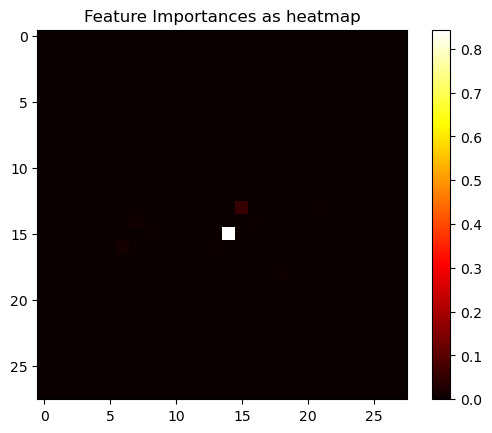

In [35]:
# only class labels 0 and 8
indices = np.logical_or(y == 0, y == 8)
X_filtered = X[indices]
y_filtered = y[indices]

# Train classifier
tree = DecisionTreeClassifier(random_state=2)
tree.fit(X_filtered, y_filtered)

# Heatmap of feature importances
feature_importances = tree.feature_importances_
feature_importances = feature_importances.reshape((img_size, img_size))
plt.figure()
plt.imshow(feature_importances, cmap="hot")
plt.title("Feature Importances as heatmap")
plt.colorbar()
plt.show()

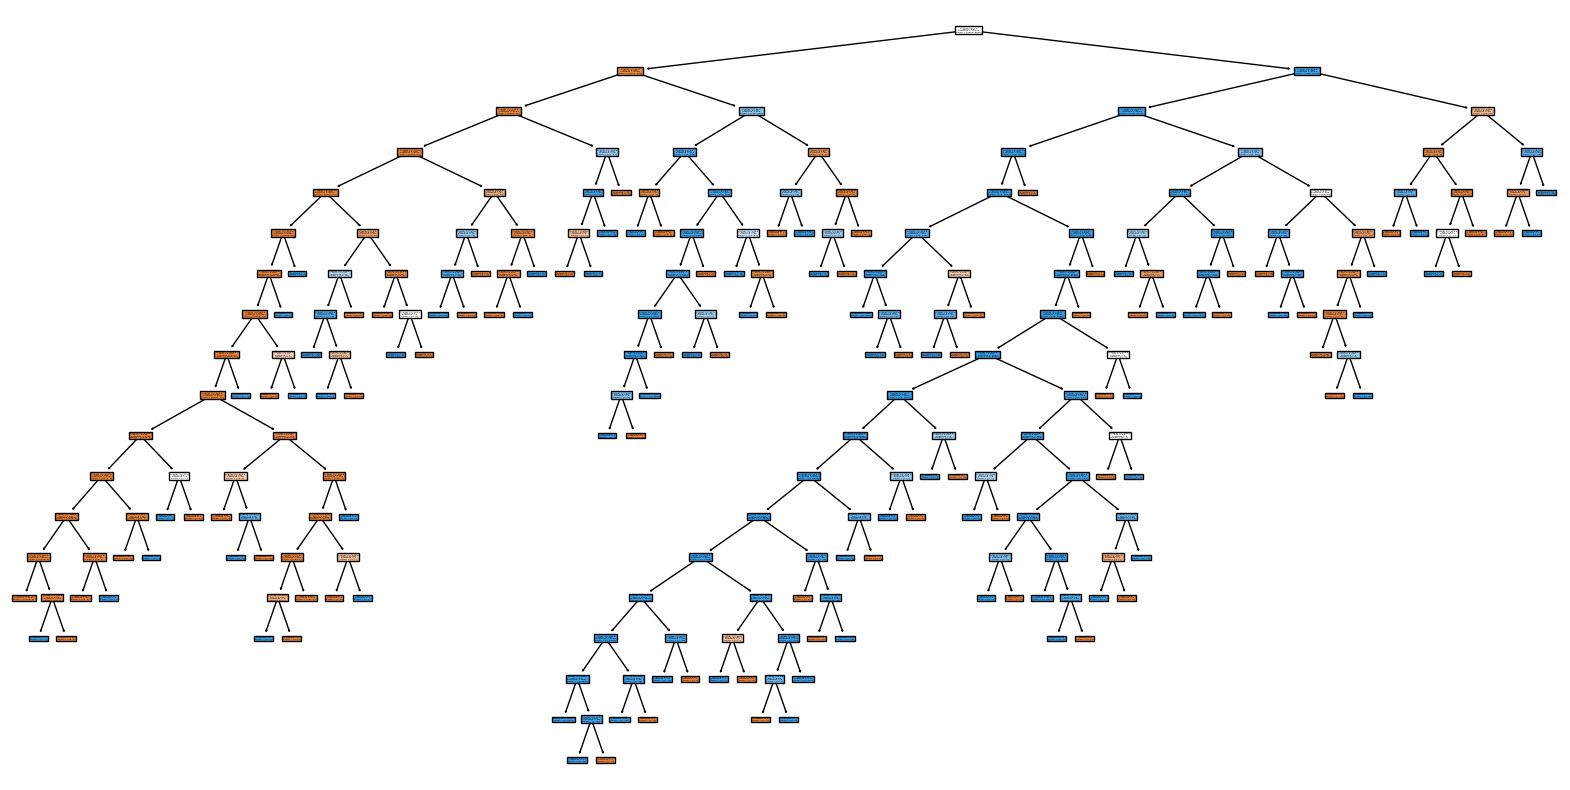

Training set accuracy: 1.0


In [36]:
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

accuracy = tree.score(X_filtered, y_filtered)
print(f"Training set accuracy: {accuracy}")

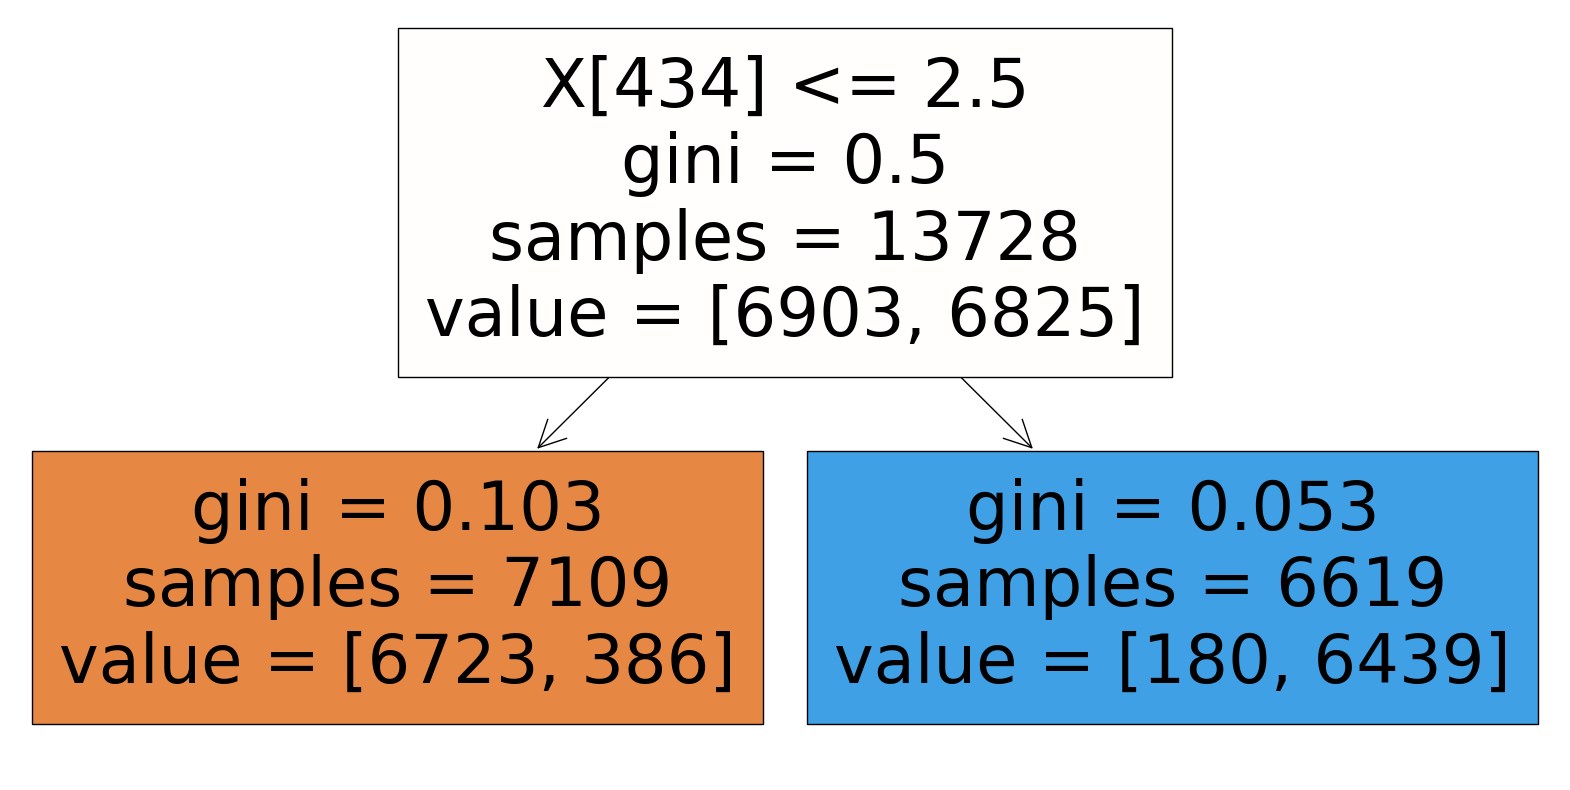

Training set accuracy: 0.9587703962703963


In [37]:
tree_pruned = DecisionTreeClassifier(random_state=2, max_depth=1)
tree_pruned.fit(X_filtered, y_filtered)
plt.figure(figsize=(20,10))
plot_tree(tree_pruned, filled=True)
plt.show()

pruned_accuracy = tree_pruned.score(X_filtered, y_filtered)
print(f"Training set accuracy: {pruned_accuracy}")

Especially the pixel in the middle is important to classify if an image belongs to the class 0 or 8. This is very explanatory and leads to an easy classification process.

The value field stands for the number of samples per class. 

## Random Forests <a class="anchor" id="three"></a>
Plot the variance for random forests with different numbers of decision trees they consist of. As shown in the paper, this should decrease. To make the classification process a bit more difficult, now all class labels (and not only 0 and 8) are considered. This provides empirical evidence to the formula proved in the paper. Each random forest is trained 100 times to get a more accurate estimation  of the variance.

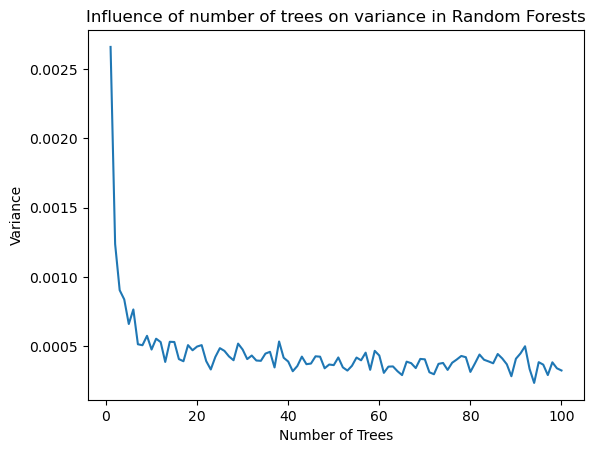

In [35]:
n_trees = range(1, 101)
variances = []

# Train random forests
for n in n_trees:
    means = []
    
    for _ in range(100):
        # Use stratify = y to make sure that the distribution of the labels is the same in both sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
        random_forest = RandomForestClassifier(n_estimators=n)
        random_forest.fit(X_train, y_train)
        trees = random_forest.estimators_

        # Get the prediction of each tree and calculate mean
        tree_pred = [tree.predict(X_test.values) for tree in trees]
        means.append(np.mean(tree_pred))
        
    variances.append(np.var(means))
    

# Plot 
plt.plot(n_trees, variances)
plt.xlabel("Number of Trees")
plt.ylabel("Variance")
plt.title("Influence of number of trees on variance in Random Forests")
plt.show()

## Gradient Boosting <a class="anchor" id="four"></a>
Bias decreases with increasing decision trees 

By training different gradient boosting classifiers on the MNIST dataset (full dataset that means all classes), the aim is to show that the bias decreases with an increasing number of decision trees. To estimate the bias more accurately, each gradient boosting classifier is trained 3 times and the results are averaged.

In [24]:
n_trees = range(1, 101)
errors_train = []
errors_test = []

# Train random forests
for n in tqdm(n_trees):
    errors_tree_train = []
    errors_tree_test = []
    
    for _ in range(3):
        # Use stratify = y to make sure that the distribution of the labels is the same in both sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
        gradient_boosting = GradientBoostingClassifier(n_estimators=n)
        gradient_boosting.fit(X_train, y_train)
        y_pred = gradient_boosting.predict(X_train)
        errors_tree_train.append(1 - accuracy_score(y_train, y_pred))
        y_pred = gradient_boosting.predict(X_test)
        errors_tree_test.append(1 - accuracy_score(y_test, y_pred))
        
    errors_train.append(np.mean(errors_tree_train))
    errors_test.append(np.mean(errors_tree_test))
    

# Plot 
plt.plot(n_trees, errors_train, label="Training")
plt.plot(n_trees, errors_test, label="Testing")
plt.xlabel("Number of Trees")
plt.ylabel("Error")
plt.title("Influence of number of trees on bias in GradientBoosting")
plt.legend()
plt.show()

  5%|███▉                                                                           | 5/100 [17:20<5:29:28, 208.09s/it]


KeyboardInterrupt: 

## Application of Decision Trees & Ensemble Methods <a class="anchor" id="five"></a>
Data taken from: [Link to Dataset](https://github.com/plotly/datasets/blob/master/diabetes.csv)

In [38]:
data = pd.read_csv("data/diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


There are 768 samples, 8 numerical features and 1 class variable with (1 = person has diabetes; 0 = person has no diabetes)

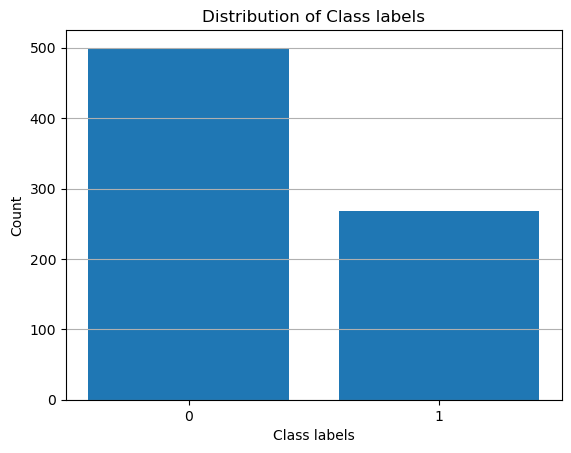

In [39]:
counts = data["Outcome"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Class labels")
plt.ylabel("Count")
plt.title("Distribution of Class labels")
plt.grid(axis="y", zorder=1)
plt.xticks([0,1])
plt.show()

The class distribution is inbalanced. There are almost twice the number of samples belonging to the class no diabetes as there are samples belonging to the class diabetes.

In [40]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

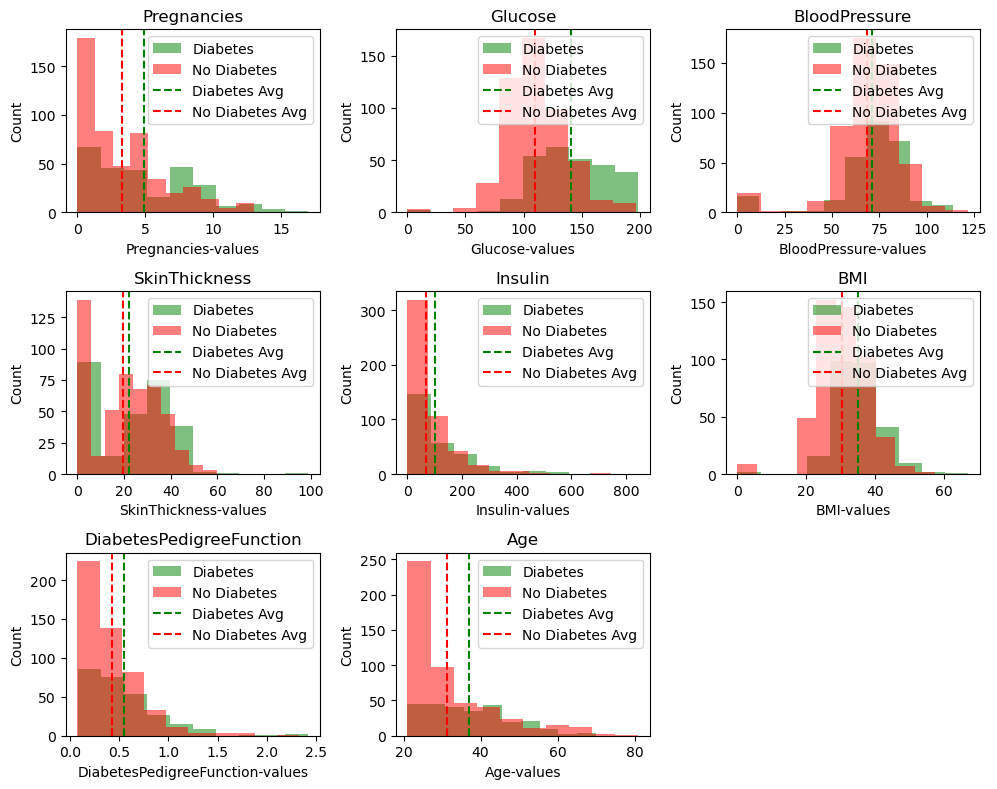

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
axs = axs.flatten()

for i in range(len(X.columns)):
    # Histogram
    axs[i].hist(X[X.columns[i]][data["Outcome"] == 1], color="green", alpha = 0.5, label="Diabetes")
    axs[i].hist(X[X.columns[i]][data["Outcome"] == 0], color="red", alpha = 0.5, label="No Diabetes")
    
    # Avg value
    avg_diabetes = X[X.columns[i]][data["Outcome"] == 1].mean()
    axs[i].axvline(avg_diabetes, color="green", linestyle="--", label="Diabetes Avg")
    avg_no_diabetes = X[X.columns[i]][data["Outcome"] == 0].mean()
    axs[i].axvline(avg_no_diabetes, color="red", linestyle="--", label="No Diabetes Avg")

    # Legend & Co.
    axs[i].set_title(X.columns[i])
    axs[i].set_xlabel(f"{X.columns[i]}-values")
    axs[i].set_ylabel("Count")
    axs[i].legend(loc = "upper right")

axs[-1].remove()  
plt.tight_layout()
plt.show()

Especially the values for glucose, age and pregnancy for diabetes and no diabetes have a significant distance to each other $\Rightarrow$ This should also be visible when displaying the decision tree. The BMI values for no-diabetes are also on average smaller than the BMI values for diabetes.

Train classifiers:

1) Decision Tree 

Balanced accuracy: 0.6461788617886179


Confusion matrix:


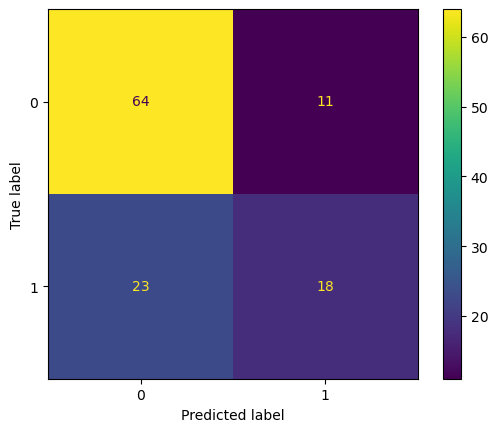

In [42]:
# 70:15:15 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state=2)

# Train decision tree without pruning
tree = DecisionTreeClassifier(random_state=2)
tree.fit(X_train, y_train)

# Get prediction
y_pred = tree.predict(X_test)

# As unbalanced dataset: balanced accuracy
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
#print(classification_report(y_val, y_pred))
print(f"\nConfusion matrix:")
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.show()

Depth of tree: 15


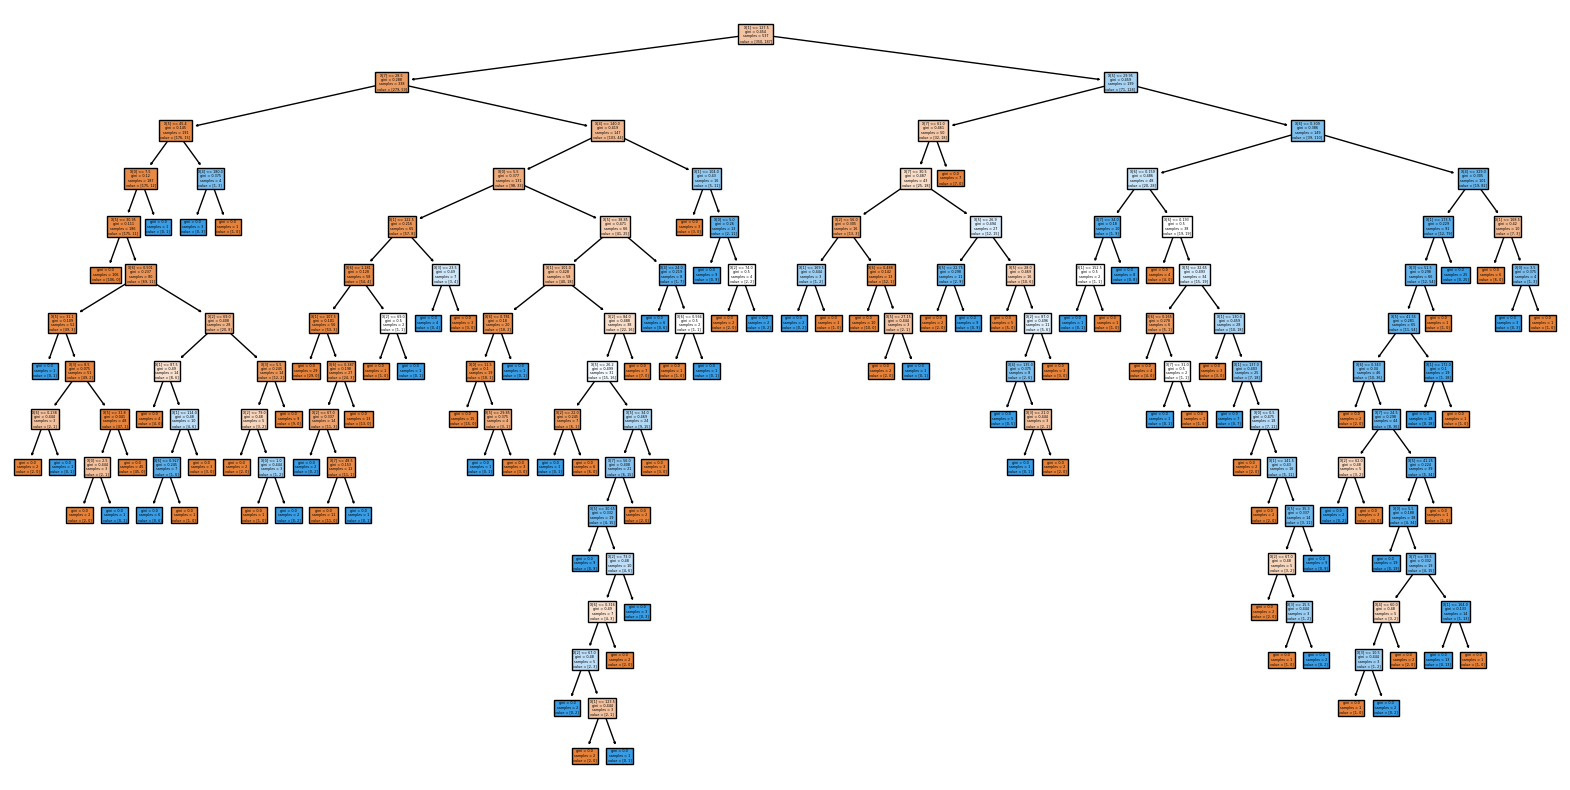

In [43]:
print(f"Depth of tree: {tree.get_depth()}")

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

Not a good performance 
- depth of tree very high -> complex tree 
- balanced accuracy low

2) Decision Tree with pruning: Test different levels of pruning on validation set

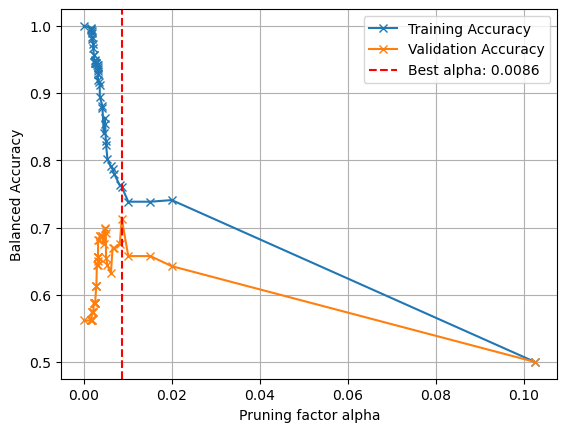

In [44]:
tree = DecisionTreeClassifier(random_state=2)

# Effective pruning values (cost complexity pruning)
alphas = tree.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

balanced_accs_val = []
balanced_accs_train = []


for a in alphas:
    tree = DecisionTreeClassifier(random_state=2, ccp_alpha=a)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_val)
    balanced_accs_val.append(balanced_accuracy_score(y_val, y_pred))
    y_pred = tree.predict(X_train)
    balanced_accs_train.append(balanced_accuracy_score(y_train, y_pred))

best_a = alphas[np.argmax(balanced_accs_val)]
plt.plot(alphas, balanced_accs_train, marker="x", label="Training Accuracy")
plt.plot(alphas, balanced_accs_val, marker="x", label="Validation Accuracy")
plt.axvline(x=best_a, color="r", linestyle="--", label=f"Best alpha: {round(best_a, 4)}")
plt.xlabel("Pruning factor alpha")
plt.ylabel("Balanced Accuracy")
plt.grid(True)
plt.legend()
plt.show()

Balanced accuracy 0.7138211382113822
Depth of tree: 3


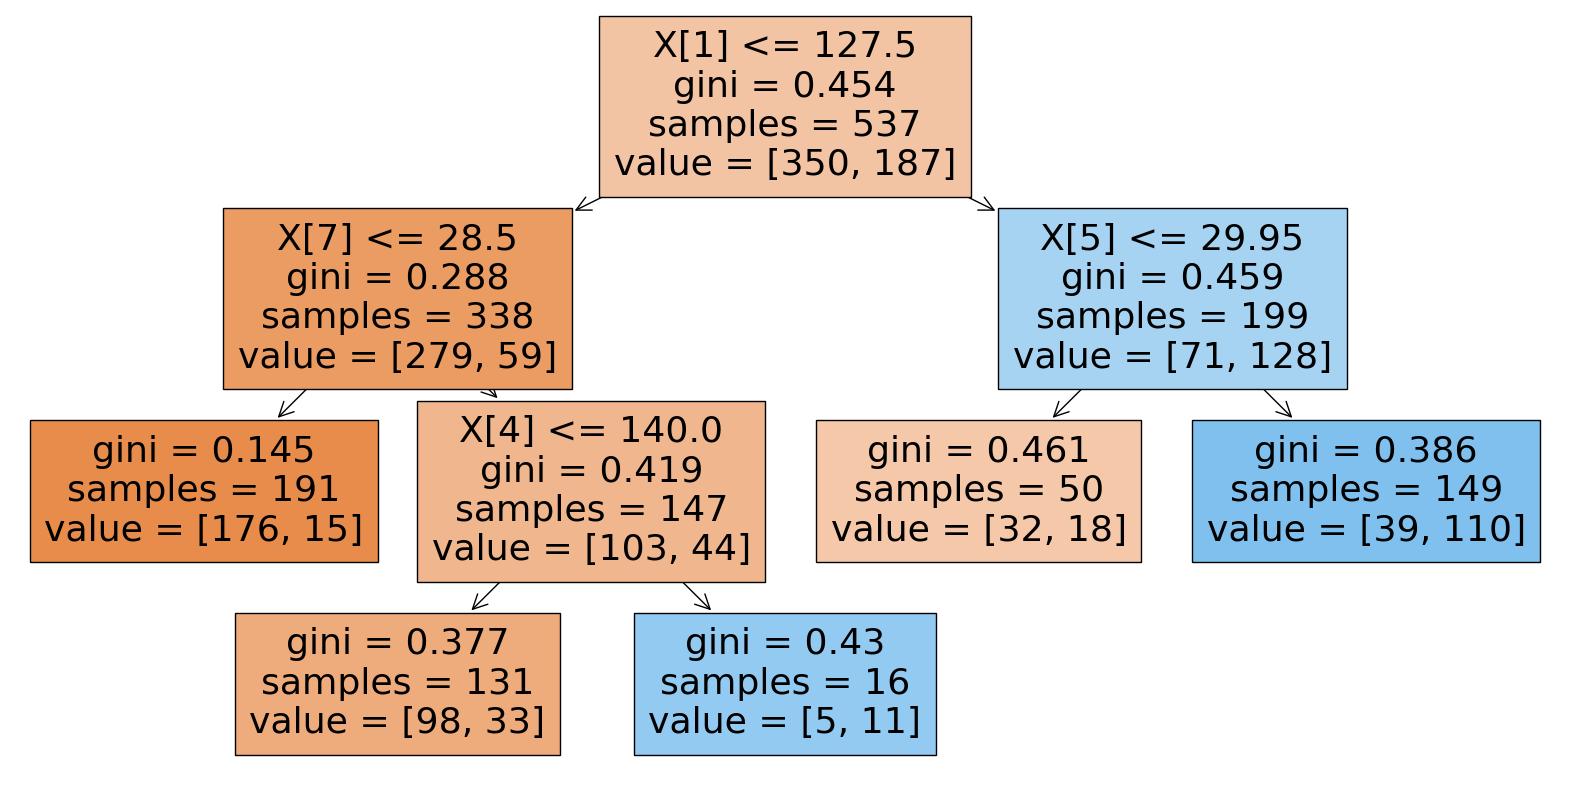

In [45]:
tree = DecisionTreeClassifier(ccp_alpha=best_a, random_state=2)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy {balanced_acc}")
print(f"Depth of tree: {tree.get_depth()}")

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

3) Random Forest

In [46]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=2)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
#print(classification_report(y_val, y_pred))
#print(f"\nConfusion matrix: \n{confusion_matrix(y_test, y_pred)}")

Balanced accuracy: 0.7460162601626016



4) Gradient Boosting

In [47]:
gradient_boosting = GradientBoostingClassifier(random_state=2)
gradient_boosting.fit(X_train, y_train)

y_pred = gradient_boosting.predict(X_test)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")

Balanced accuracy: 0.7515447154471544

